### Model Selection. 

After we defined the Preprocessing for the ML algorithm, we will try with different models in order to choose an appropiate one for the forecasting of the next period. Also, we will choose the relevant features for the different models.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

import pickle

from preprocessing_ml.scripts import make_training_dataframe, subdict_metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Lars, ElasticNet, OrthogonalMatchingPursuit

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

data = pd.read_csv('../input/preprocess_data/to_train.csv', index_col=['Unnamed: 0'])

#Importing the encoding dicitionary
with open('../models/objects/dict_encoders.pickle','rb') as handle:
    dict_encoders = pickle.load(handle)
    
data.drop(['Tasa hipotecaria Trimestral'],axis=1,inplace=True)

##### Outliers

In [3]:
to_replace_11 = data[data['Piso de ubicación'] > 10].index
data.loc[to_replace_11,'Piso de ubicación'] = 11

In [4]:
to_drop = data[data['Superficie '] >= data['Superficie '].quantile(.99)].index
data.drop(to_drop, axis=0,inplace=True)

##### Correlations

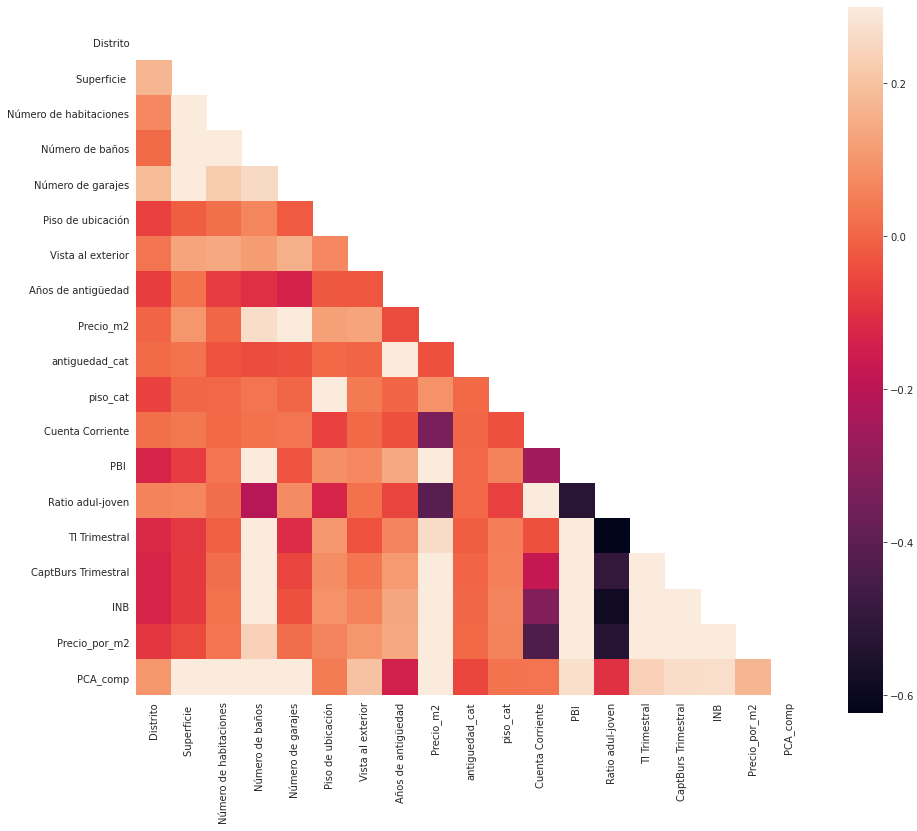

In [4]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15,13))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

In [29]:
### Get dummies variables.
data = pd.get_dummies(data, columns=['antiguedad_cat','piso_cat'],drop_first=True)

### Backtesting:

###### Linear models

In [30]:

def train_and_generate_metrics(to_train, model, dict_encoders, model_number='', model_name='LR'):
    """
    SPANISH: 
    Por ahora, iteraremos por cada periodo, para ver la métrica de interés dentro del dataset.
    Nos enfocaremos en analizar la media y desviación estándar de las métricas que son sensibles o están
    siendo afectadas por el logaritmo.
    
    
    Requirements:
    La función tiene que ser apta para poder correr varias veces y almacenar resultados en un diccionario.
    La función tiene que darnos un dicc preferible de la forma:
    
    dicc = {'Modelo_1': {parametros : {A :1, 
                                    B:2, C:3},
                       metricas : {mae: 0.1, mse: 0.2, ..., mape: 0.3}}}
    
    El resultado será un diccionario con:
    {'Total_mean':{'mae':0.2, 'mse': 0.3, ... 'mape':0.002},
     'Total_std':{mae':0.2, 'mse': 0.3, ... 'mape':0.002}}
     
     Para poder almacenarlo. 
    ------------------------------------------------------------------------------------------------------
    params:
    - dicc_params : A dict of dicts, with sklearn object as a keys.
                    {LinearRegression: {'C':1.2},
                     Lasso : {'alpha':1.2}}
    """
    global prototyping_districts
    
    prototyping_districts = ['surco', 'miraflores', 'la molina', 'san borja', 'san isidro', 
                         'san miguel', 'magdalena', 'jesús maría', 'pueblo libre', 'lince', 'barranco']
    
    predictions_dict = {}
    original_values_dict = {}

    dict_districts_preds = {} 
    dict_districts_actuals = {}

    dict_districs_metrics = {district: [] for district in prototyping_districts }
    final_metrics_df = pd.DataFrame()

    for n in range(60, len(to_train['Fecha'].unique()[:-5])):

        #Initializing values:

        #iterate with expanding window dataset.
        training_data, testing_data, testing_date = make_training_dataframe(to_train, window_size=n)

        X_train, y_train = training_data.drop('target',axis=1), training_data['target']
        X_test, y_test = testing_data.drop('target',axis=1), testing_data['target']

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        #For the total:
        predictions_dict[testing_date] = predictions #Predictions

        original_values_dict[testing_date] = y_test #Actuals

        X_test['predictions'] = np.exp(predictions)
        X_test['actuals'] = np.exp(y_test)

        #---------------CAVEAT: There is data_distritos_preds and dict_districts_preds... !!!! FIX IT!!!!

        data_distritos_preds = X_test.groupby('Distrito')[['predictions']].agg('median').reset_index()
        #Calling inverse encoding on Districts.
        data_distritos_preds['Distrito'] = dict_encoders['Distrito'].inverse_transform(data_distritos_preds['Distrito'].values.astype(int))
        dict_districts_preds[testing_date] = data_distritos_preds.to_dict() #I changed to testing_date

        data_districts_actuals = X_test.groupby('Distrito')[['actuals']].agg('median').reset_index()
        #Calling inverse encoding on Districts.
        data_districts_actuals['Distrito'] = dict_encoders['Distrito'].inverse_transform(data_districts_actuals['Distrito'].values.astype(int))
        dict_districts_actuals[testing_date] = data_districts_actuals.to_dict()

        #acá tengo que generar las métricas, e imprimir los resultados:

        for district in X_test['Distrito'].unique():
            preds_district = X_test[X_test['Distrito']==district]['predictions']
            actuals_district = X_test[X_test['Distrito'] == district]['actuals']

            dict_districs_metrics[dict_encoders['Distrito'].inverse_transform([int(district)])[0]] = subdict_metrics(actuals_district, preds_district)
        
        if isinstance(testing_date,str):
            test_year_time = testing_date.split('-')[0]
            test_month_time = testing_date.split('-')[1]
        else:
            test_year_time = np.datetime_as_string(testing_date).split('-')[0]
            test_month_time = np.datetime_as_string(testing_date).split('-')[1]

        #display(HTML('<p style="text-align:center"> RESULTADOS PARA EL PERIODO {}</p>'.format(
            #test_year_time + ' - ' + test_month_time)))

        df_temporal_results = pd.DataFrame(dict_districs_metrics).T.sort_values(by=['R2'],ascending=False)

        to_append = pd.DataFrame({metric : df_temporal_results[metric].mean() for metric\
                                                 in df_temporal_results.columns},\
                                 index=['Lima_{}_{}'.format(test_year_time,test_month_time)])

        df_temporal_results = df_temporal_results.append(to_append)
        final_metrics_df = final_metrics_df.append(to_append)
    
    metrics_mean = pd.DataFrame({metric : final_metrics_df[metric].mean() for metric\
                                             in final_metrics_df.columns},\
                                 index=['{}{}_mean'.format(model_name, model_number)])
    
    metrics_std = pd.DataFrame({metric : final_metrics_df[metric].std() for metric\
                                             in final_metrics_df.columns},\
                                 index=['{}{}_std'.format(model_name,model_number)])
    print(metrics_mean)
    return metrics_mean, metrics_std

In [31]:
dicc_params = {Lasso:[
               {'alpha':0.025, 'normalize':True},
               {'alpha': 0.050, 'normalize': True},
               {'alpha': 0.075, 'normalize': True},
               {'alpha': 0.20, 'normalize':True},
               {'alpha': 0.50, 'normalize':True},
               {'alpha': 0.75, 'normalize':True},
               {'alpha': 1.0, 'normalize':True},
               {'alpha': 1.5, 'normalize':True},
               {'alpha': 1.5, 'normalize':False}],
               
               LinearRegression: [
               {'fit_intercept':True,'normalize':True},
               {'fit_intercept' : False, 'normalize':True},
               {'fit_intercept':True, 'normalize':False},
               {'fit_intercept': False, 'normalize':False}],
               
               Ridge : [
                   {'alpha':200,'normalize':True},
                   {'alpha':250,'normalize':True},
                   {'alpha':300,'normalize':True},
                   {'alpha':350,'normalize':True},
                   {'alpha':400,'normalize':True},
                   {'alpha':450,'normalize':True},
                   {'alpha':500,'normalize':True},
                   {'alpha':550,'normalize':True},
                   {'alpha':600,'normalize':True}
               ],
               
               Lars : [
                   {'n_nonzero_coefs':1, 'normalize':True}
               ]
               
               }

dicc_params_lr = {LinearRegression: [
    {'fit_intercept':True, 'normalize':False}
]}

In [32]:
def backtesting_models(dicc_params, to_train):
    """
    dicc_params would be a dictionary of list of dictionaries as:
    
    --------------------------------------------------------------------------------------
    - diccc_params: A dict of dicts, with sklearn object as a keys.
                    
    dicc_params = {LinearRegression: [
               {'fit_intercept':True,'normalize':True},
               {'fit_intercept' : False, 'normalize':True},
               {'fit_intercept':True, 'normalize':False},
               {'fit_intercept': False, 'normalize':False}]
               Lasso:
               {'alpha':1.2, 'normalize':True},
               {'alpha': 2, 'normalize': True},
               {'alpha': 0.8, 'normalize': True},
               {'alpha': 0.2, 'normalize':True}}
               
    - to_train: DataFrame with data and Date columns as 'Fecha'.
    
    """
    n = 1
    results = pd.DataFrame()
    for _model, list_params in dicc_params.items():
        #Initialize parameters.
        model_num = 1
        for params in list_params:
            model_num += 1
            model = _model(**params)
            print(_model.__name__)
            warnings.filterwarnings('ignore')
            print(params)
            metrics_mean, metrics_std = train_and_generate_metrics(to_train, model, dict_encoders, model_number = str(model_num), model_name = _model.__name__)
            results = results.append(metrics_mean).append(metrics_std)
            print('Iteracion numero {} de {}'.format(n, len(list_params)*2))
            n+=1
    return results

In [33]:
results = backtesting_models(dicc_params_lr, data)

LinearRegression
{'fit_intercept': True, 'normalize': False}
TRAIN_DATA: From 2014-04-01 to 2015-04-01
TRAIN_DATA: From 2014-07-01 to 2015-07-01
TRAIN_DATA: From 2014-10-01 to 2015-10-01
TRAIN_DATA: From 2015-01-01 to 2016-01-01
TRAIN_DATA: From 2015-04-01 to 2016-04-01
TRAIN_DATA: From 2015-07-01 to 2016-07-01
TRAIN_DATA: From 2015-10-01 to 2016-10-01
TRAIN_DATA: From 2016-01-01 to 2017-01-01
TRAIN_DATA: From 2016-04-01 to 2017-04-01
TRAIN_DATA: From 2016-07-01 to 2017-07-01
TRAIN_DATA: From 2016-10-01 to 2017-10-01
TRAIN_DATA: From 2017-01-01 to 2018-01-01
TRAIN_DATA: From 2017-04-01 to 2018-04-01
TRAIN_DATA: From 2017-07-01 to 2018-07-01
                              MAE          MSE        RMSE        R2  \
LinearRegression2_mean  621.04261  784701.9564  821.116414  0.086734   

                           RMSLE      MAPE  
LinearRegression2_mean  0.183505  0.144483  
Iteracion numero 1 de 2


In [113]:
results

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Lasso2_mean,1631.653334,4.162544e+06,1854.355250,-3.621662,0.452487,0.321743
Lasso2_std,158.565118,7.104693e+05,165.323647,1.056039,0.041947,0.026544
Lasso3_mean,1631.653334,4.162544e+06,1854.355250,-3.621662,0.452487,0.321743
Lasso3_std,158.565118,7.104693e+05,165.323647,1.056039,0.041947,0.026544
Lasso4_mean,1631.653334,4.162544e+06,1854.355250,-3.621662,0.452487,0.321743
Lasso4_std,158.565118,7.104693e+05,165.323647,1.056039,0.041947,0.026544
Lasso5_mean,1631.653334,4.162544e+06,1854.355250,-3.621662,0.452487,0.321743
Lasso5_std,158.565118,7.104693e+05,165.323647,1.056039,0.041947,0.026544
Lasso6_mean,1631.653334,4.162544e+06,1854.355250,-3.621662,0.452487,0.321743
Lasso6_std,158.565118,7.104693e+05,165.323647,1.056039,0.041947,0.026544


##### Tree-based models

In [35]:
dicc_params_tree = {RandomForestRegressor:[
               {'n_estimators':250, 'max_depth':10,'n_jobs':-1,'min_impurity_decrease':0.0},
               {'n_estimators': 200, 'max_depth': 15,'n_jobs':-1,'min_impurity_decrease':0.0},
               {'n_estimators': 100, 'max_depth': 10,'n_jobs':-1,'min_impurity_decrease':0.0},
               {'n_estimators': 500, 'max_depth': 18,'n_jobs':-1,'min_impurity_decrease':0.0},
               {'n_estimators': 250, 'max_depth': 20,'n_jobs':-1,'min_impurity_decrease':0.010},
               {'n_estimators': 250, 'max_depth': 15,'n_jobs':-1,'min_impurity_decrease':0.075},
               {'n_estimators': 250, 'max_depth':15,'n_jobs':-1,'min_impurity_decrease':1.025},
               {'n_estimators': 250, 'max_depth':15,'n_jobs':-1,'min_impurity_decrease':2.0},
               {'n_estimators': 250, 'max_depth':15,'n_jobs':-1,'min_impurity_decrease':1.5}]
               #More models were tried... but with no interest results, except for extra trees.
                   }

In [1]:
results = backtesting_models(dicc_params, data)

In [12]:
results

,MAE,MSE,RMSE,R2,RMSLE,MAPE
RandomForestRegressor2_mean,642.513006,8.729025e+05,860.489014,0.046413,0.188863,0.147918
RandomForestRegressor2_std,39.831369,2.146541e+05,73.886694,0.086711,0.019137,0.016842
RandomForestRegressor3_mean,651.482018,8.933944e+05,871.350677,0.019528,0.191085,0.149488
RandomForestRegressor3_std,37.921785,2.130497e+05,72.098749,0.088409,0.018578,0.015915
RandomForestRegressor4_mean,642.993266,8.740593e+05,860.453896,0.048678,0.188939,0.148049
RandomForestRegressor4_std,38.255621,2.105501e+05,70.989421,0.080533,0.018442,0.016080
RandomForestRegressor5_mean,647.887668,8.869983e+05,868.163943,0.026407,0.190391,0.148586
RandomForestRegressor5_std,36.712637,2.122662e+05,71.179040,0.088315,0.018371,0.015873
RandomForestRegressor6_mean,798.723658,1.317116e+06,1029.983027,-0.332438,0.222732,0.171275
RandomForestRegressor6_std,64.543795,2.881893e+05,87.070498,0.162288,0.016593,0.014281


In [36]:
dicc_params_tree = {ExtraTreesRegressor:[
               {'n_estimators':550, 'max_depth':10,'n_jobs':-1,'min_impurity_decrease':0.0}]
               }

In [37]:
results = backtesting_models(dicc_params_tree, data)

ExtraTreesRegressor
{'n_estimators': 550, 'max_depth': 10, 'n_jobs': -1, 'min_impurity_decrease': 0.0}
TRAIN_DATA: From 2014-04-01 to 2015-04-01
TRAIN_DATA: From 2014-07-01 to 2015-07-01
TRAIN_DATA: From 2014-10-01 to 2015-10-01
TRAIN_DATA: From 2015-01-01 to 2016-01-01
TRAIN_DATA: From 2015-04-01 to 2016-04-01
TRAIN_DATA: From 2015-07-01 to 2016-07-01
TRAIN_DATA: From 2015-10-01 to 2016-10-01
TRAIN_DATA: From 2016-01-01 to 2017-01-01
TRAIN_DATA: From 2016-04-01 to 2017-04-01
TRAIN_DATA: From 2016-07-01 to 2017-07-01
TRAIN_DATA: From 2016-10-01 to 2017-10-01
TRAIN_DATA: From 2017-01-01 to 2018-01-01
TRAIN_DATA: From 2017-04-01 to 2018-04-01
TRAIN_DATA: From 2017-07-01 to 2018-07-01
                                  MAE            MSE        RMSE        R2  \
ExtraTreesRegressor2_mean  617.901595  800222.662489  824.365393  0.094588   

                              RMSLE      MAPE  
ExtraTreesRegressor2_mean  0.183169  0.142569  
Iteracion numero 1 de 2


In [16]:
results = backtesting_models(dicc_params_tree, data)

ExtraTreesRegressor
{'n_estimators': 550, 'max_depth': 10, 'n_jobs': -1, 'min_impurity_decrease': 0.0}
TRAIN_DATA: From 2014-04-01 to 2015-04-01
TRAIN_DATA: From 2014-07-01 to 2015-07-01
TRAIN_DATA: From 2014-10-01 to 2015-10-01
TRAIN_DATA: From 2015-01-01 to 2016-01-01
TRAIN_DATA: From 2015-04-01 to 2016-04-01
TRAIN_DATA: From 2015-07-01 to 2016-07-01
TRAIN_DATA: From 2015-10-01 to 2016-10-01
TRAIN_DATA: From 2016-01-01 to 2017-01-01
TRAIN_DATA: From 2016-04-01 to 2017-04-01
TRAIN_DATA: From 2016-07-01 to 2017-07-01
TRAIN_DATA: From 2016-10-01 to 2017-10-01
TRAIN_DATA: From 2017-01-01 to 2018-01-01
TRAIN_DATA: From 2017-04-01 to 2018-04-01
TRAIN_DATA: From 2017-07-01 to 2018-07-01
                                  MAE            MSE        RMSE        R2  \
ExtraTreesRegressor2_mean  630.435211  865373.523709  850.411949  0.083619   

                              RMSLE      MAPE  
ExtraTreesRegressor2_mean  0.186307  0.144502  
Iteracion numero 1 de 2


#### From this results we can say:

- Since ExtraTrees and Vanilla Linear Regression are the best models fitted:
    - The RMSLE and MAPE shows the model mostly underestimate the predicted value.
    - R-squared is near to zero, so the model is slightly better than predict with the mean.
    - The models are relatively stable, since the standard deviation is not pronounced and acceptable (6-8% around the mean)

- Its requiere more Exploratory Data Analysis in order to see nuances between districts.

From this insights, we would analize the errors and get the outliers and the pronounced underestimations. Also, we should see which variables are affecting more this predictions with SHAP values. Finally, we would see between the differences of predictions of these two models (Extratrees and LinearRegression)

###### 1. Error Analysis

In [18]:
w_s = 73  #In order to get the last 5 periods for train and test.
warnings.filterwarnings('ignore')
train_data, test_data, testing_dates = make_training_dataframe(data, window_size=73)

X_train, y_train = train_data.drop('target',axis=1), train_data['target']

lr = LinearRegression(fit_intercept=True, normalize=True)
lr.fit(X_train,y_train)

predictions = lr.predict(test_data.drop('target',axis=1))

errors = pd.DataFrame({'actuals':np.exp(test_data['target']), 'predictions': np.exp(predictions),\
                       'distritos': dict_encoders['Distrito'].inverse_transform(test_data['Distrito'].astype(int)),\
                      'PCA_index': test_data['PCA_comp']})

errors['diferencias'] = errors['predictions'] - errors['actuals'] #Negatives values indicate understimations.
errors.sort_values('diferencias')

TRAIN_DATA: From 2017-07-01 to 2018-07-01


,actuals,predictions,distritos,PCA_index,diferencias
182,9960.790023,6306.693474,miraflores,3.426930,-3654.096549
170,8969.265819,5518.644967,san isidro,3.347678,-3450.620853
13,6977.121010,3951.933890,lince,0.588169,-3025.187120
212,7256.402528,4763.858317,magdalena,4.334005,-2492.544211
46,5866.273479,3616.070380,la molina,1.502467,-2250.203099
...,...,...,...,...,...
164,3470.878475,4614.231373,magdalena,3.316170,1143.352898
203,2455.390983,3671.212155,san miguel,4.072099,1215.821173
214,4724.167138,6111.910220,miraflores,4.684554,1387.743082
156,4440.265224,5899.160133,san isidro,3.021549,1458.894909


<AxesSubplot:xlabel='diferencias', ylabel='Density'>

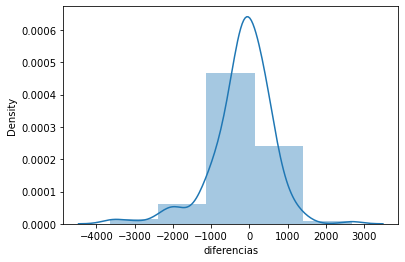

In [19]:
sns.distplot(errors['diferencias'],bins=5)

In [16]:
errors['dif_cat'] = pd.cut(errors['diferencias'], 5, labels=['underestimated_2','underestimated_1','acceptable',\
                                                             'acceptable',
                                                         'over_estimated'],ordered=False)
#Do we have a problem in San isidro/Barranco districts?
pd.crosstab(errors.distritos,errors.dif_cat).sort_values(by='underestimated_1')

#How the algorithm can notice this?

dif_cat,acceptable,over_estimated,underestimated_1,underestimated_2
distritos,,,,
lince,11,0,0,1
pueblo libre,14,0,0,0
san borja,18,0,0,0
surco,17,0,0,0
jesús maría,19,0,1,0
la molina,19,0,1,0
magdalena,21,0,1,1
san miguel,16,0,1,0
miraflores,25,0,2,1


In [26]:
pd.DataFrame({'features':X_train.columns, 'importance':lr.coef_}).sort_values('importance')

,features,importance
15,Ratio adul-joven_LAG_3,-3.085691e+02
13,Ratio adul-joven_LAG_1,-1.588244e+02
29,LAG_4_isna,-1.076482e-02
17,TI Trimestral_LAG_1,-2.675806e-03
27,LAG_2_isna,-2.254433e-03
28,LAG_3_isna,-7.789271e-04
19,TI Trimestral_LAG_3,-4.880099e-04
6,INB_LAG_2,-2.858662e-04
21,Distrito,-1.581089e-04
11,PBI _LAG_3,-6.108030e-06
